In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the "../data/" directory.
# will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../data/train_image_data_2.parquet
../data/train_image_data_3.parquet
../data/train_image_data_1.parquet
../data/test.csv
../data/train_image_data_0.parquet
../data/test_image_data_1.parquet
../data/test_image_data_0.parquet
../data/train.csv
../data/test_image_data_2.parquet
../data/class_map.csv
../data/test_image_data_3.parquet
../data/sample_submission.csv
../data/kalpurush.ttf
../data/submission.csv


In [4]:
train_df_ = pd.read_csv('../data/train.csv')
test_df_ = pd.read_csv('../data/test.csv')
class_map_df = pd.read_csv('../data/class_map.csv')
sample_sub_df = pd.read_csv('../data/sample_submission.csv')

In [21]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [22]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [23]:
train_df_

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic
0,Train_0,15,9,5
1,Train_1,159,0,0
2,Train_2,22,3,5
3,Train_3,53,2,2
4,Train_4,71,9,5
5,Train_5,153,9,0
6,Train_6,52,2,0
7,Train_7,139,3,0
8,Train_8,67,0,0
9,Train_9,64,7,1


In [24]:
IMG_SIZE=64
N_CHANNELS=1

In [25]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [26]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

In [27]:
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

W0430 03:26:15.260549 140011596736320 deprecation.py:506] From /usr/lib/python3.6/site-packages/tensorflow/python/training/moving_averages.py:210: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0430 03:26:15.352350 140011596736320 deprecation.py:506] From /usr/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [29]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [32]:
batch_size = 256
epochs = 30

In [33]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [34]:
HEIGHT = 137
WIDTH = 236

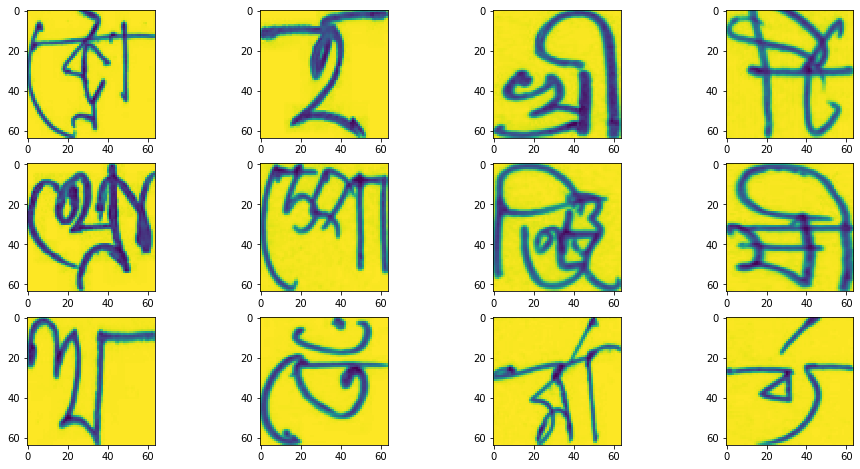


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 45s 251ms/step - loss: 7.9296 - dense_3_loss: 4.7690 - dense_4_loss: 1.9588 - dense_5_loss: 1.2018 - dense_3_acc: 0.0289 - dense_4_acc: 0.3014 - dense_5_acc: 0.6198 - val_loss: 6.9602 - val_dense_3_loss: 4.6273 - val_dense_4_loss: 1.2698 - val_dense_5_loss: 1.0632 - val_dense_3_acc: 0.0346 - val_dense_4_acc: 0.5873 - val_dense_5_acc: 0.6293
Epoch 2/30


/usr/lib64/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `dense_3_accuracy` which is not available. Available metrics are: val_loss,val_dense_3_loss,val_dense_4_loss,val_dense_5_loss,val_dense_3_acc,val_dense_4_acc,val_dense_5_acc,loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_3_acc,dense_4_acc,dense_5_acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/lib64/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `dense_4_accuracy` which is not available. Available metrics are: val_loss,val_dense_3_loss,val_dense_4_loss,val_dense_5_loss,val_dense_3_acc,val_dense_4_acc,val_dense_5_acc,loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_3_acc,dense_4_acc,dense_5_acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/lib64/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `dens

180/180 [==============================] - 40s 220ms/step - loss: 6.8134 - dense_3_loss: 4.5078 - dense_4_loss: 1.2928 - dense_5_loss: 1.0128 - dense_3_acc: 0.0430 - dense_4_acc: 0.5542 - dense_5_acc: 0.6495 - val_loss: 5.8774 - val_dense_3_loss: 4.2299 - val_dense_4_loss: 0.8216 - val_dense_5_loss: 0.8259 - val_dense_3_acc: 0.0545 - val_dense_4_acc: 0.7259 - val_dense_5_acc: 0.7055
Epoch 3/30
180/180 [==============================] - 40s 223ms/step - loss: 6.1701 - dense_3_loss: 4.1888 - dense_4_loss: 1.0896 - dense_5_loss: 0.8917 - dense_3_acc: 0.0696 - dense_4_acc: 0.6257 - dense_5_acc: 0.6853 - val_loss: 5.1299 - val_dense_3_loss: 3.7344 - val_dense_4_loss: 0.6780 - val_dense_5_loss: 0.7175 - val_dense_3_acc: 0.1026 - val_dense_4_acc: 0.7757 - val_dense_5_acc: 0.7274
Epoch 4/30
180/180 [==============================] - 42s 234ms/step - loss: 5.2991 - dense_3_loss: 3.6812 - dense_4_loss: 0.9011 - dense_5_loss: 0.7168 - dense_3_acc: 0.1248 - dense_4_acc: 0.6978 - dense_5_acc: 0.749

Epoch 23/30
180/180 [==============================] - 66s 366ms/step - loss: 1.1919 - dense_3_loss: 0.7103 - dense_4_loss: 0.2818 - dense_5_loss: 0.1997 - dense_3_acc: 0.7969 - dense_4_acc: 0.9126 - dense_5_acc: 0.9333 - val_loss: 0.7066 - val_dense_3_loss: 0.4731 - val_dense_4_loss: 0.1246 - val_dense_5_loss: 0.1089 - val_dense_3_acc: 0.8720 - val_dense_4_acc: 0.9671 - val_dense_5_acc: 0.9669
Epoch 24/30
180/180 [==============================] - 66s 366ms/step - loss: 1.1105 - dense_3_loss: 0.6421 - dense_4_loss: 0.2741 - dense_5_loss: 0.1944 - dense_3_acc: 0.8126 - dense_4_acc: 0.9155 - dense_5_acc: 0.9370 - val_loss: 0.7896 - val_dense_3_loss: 0.5294 - val_dense_4_loss: 0.1405 - val_dense_5_loss: 0.1197 - val_dense_3_acc: 0.8561 - val_dense_4_acc: 0.9562 - val_dense_5_acc: 0.9599
Epoch 25/30
180/180 [==============================] - 64s 354ms/step - loss: 1.2057 - dense_3_loss: 0.7028 - dense_4_loss: 0.2963 - dense_5_loss: 0.2066 - dense_3_acc: 0.7977 - dense_4_acc: 0.9089 - dens

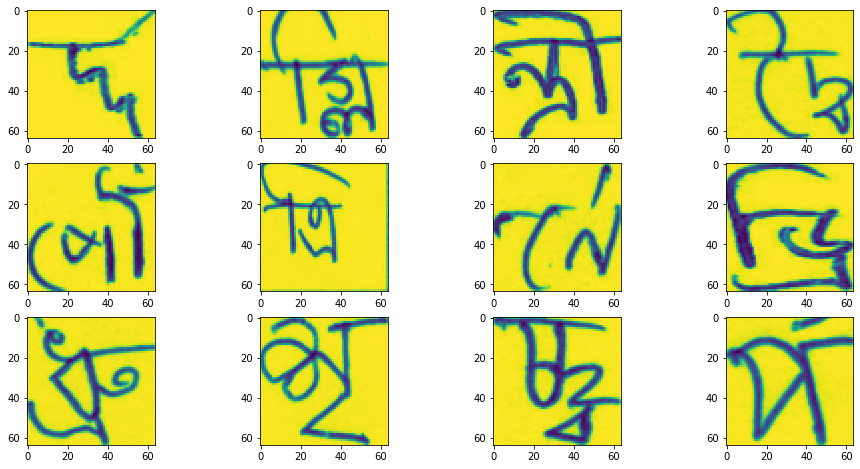


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 41s 225ms/step - loss: 1.4877 - dense_3_loss: 0.8991 - dense_4_loss: 0.3413 - dense_5_loss: 0.2473 - dense_3_acc: 0.7549 - dense_4_acc: 0.8941 - dense_5_acc: 0.9219 - val_loss: 0.7169 - val_dense_3_loss: 0.4254 - val_dense_4_loss: 0.1437 - val_dense_5_loss: 0.1478 - val_dense_3_acc: 0.8753 - val_dense_4_acc: 0.9549 - val_dense_5_acc: 0.9525
Epoch 2/30
180/180 [==============================] - 47s 264ms/step - loss: 1.2332 - dense_3_loss: 0.7286 - dense_4_loss: 0.2895 - dense_5_loss: 0.2151 - dense_3_acc: 0.7948 - dense_4_acc: 0.9107 - dense_5_acc: 0.9314 - val_loss: 0.6384 - val_dense_3_loss: 0.3971 - val_dense_4_loss: 0.1395 - val_dense_5_loss: 0.1018 - val_dense_3_acc: 0.8823 - val_dense_4_acc: 0.9592 - val_dense_5_acc: 0.9699
Epoch 3/30
180/180 [==============================] - 55s 30

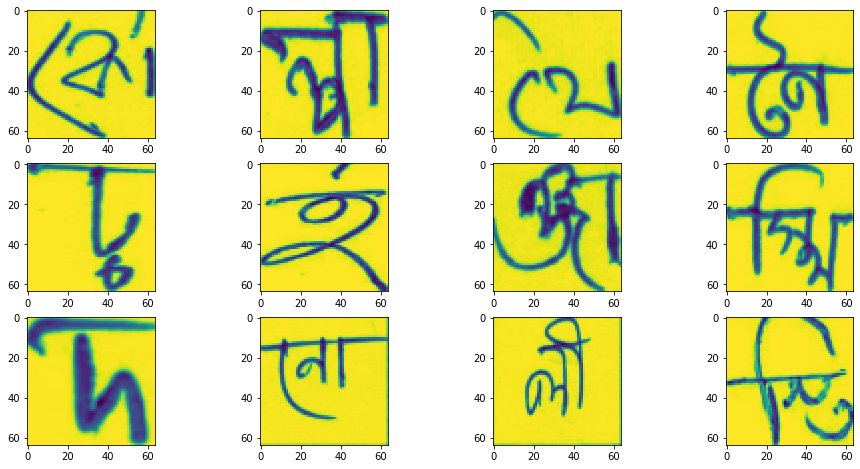


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 41s 225ms/step - loss: 0.8856 - dense_3_loss: 0.5179 - dense_4_loss: 0.2129 - dense_5_loss: 0.1547 - dense_3_acc: 0.8582 - dense_4_acc: 0.9380 - dense_5_acc: 0.9530 - val_loss: 0.4601 - val_dense_3_loss: 0.2830 - val_dense_4_loss: 0.0951 - val_dense_5_loss: 0.0820 - val_dense_3_acc: 0.9193 - val_dense_4_acc: 0.9781 - val_dense_5_acc: 0.9759
Epoch 2/30
180/180 [==============================] - 48s 267ms/step - loss: 0.7774 - dense_3_loss: 0.4420 - dense_4_loss: 0.1957 - dense_5_loss: 0.1397 - dense_3_acc: 0.8743 - dense_4_acc: 0.9418 - dense_5_acc: 0.9570 - val_loss: 0.8205 - val_dense_3_loss: 0.3398 - val_dense_4_loss: 0.3667 - val_dense_5_loss: 0.1140 - val_dense_3_acc: 0.9081 - val_dense_4_acc: 0.8847 - val_dense_5_acc: 0.9669
Epoch 3/30
180/180 [==============================] - 64s 35

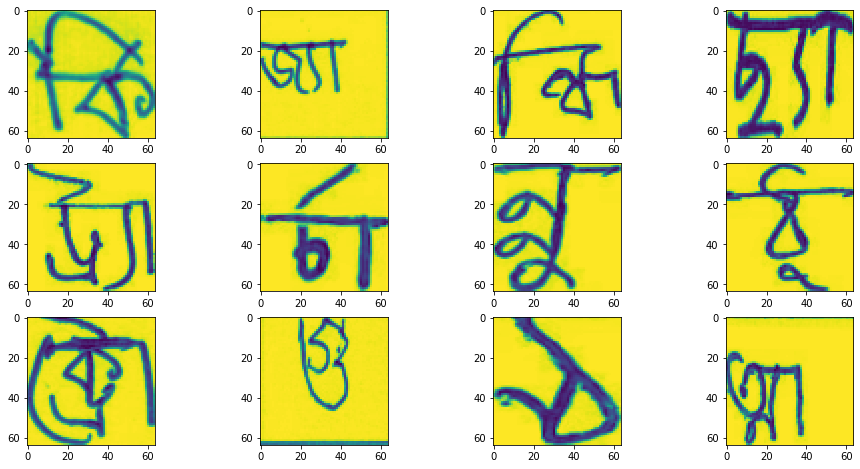


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 41s 225ms/step - loss: 0.7494 - dense_3_loss: 0.4293 - dense_4_loss: 0.1875 - dense_5_loss: 0.1326 - dense_3_acc: 0.8818 - dense_4_acc: 0.9467 - dense_5_acc: 0.9612 - val_loss: 0.4012 - val_dense_3_loss: 0.2477 - val_dense_4_loss: 0.0893 - val_dense_5_loss: 0.0642 - val_dense_3_acc: 0.9310 - val_dense_4_acc: 0.9776 - val_dense_5_acc: 0.9821
Epoch 2/30
180/180 [==============================] - 52s 290ms/step - loss: 0.6240 - dense_3_loss: 0.3486 - dense_4_loss: 0.1595 - dense_5_loss: 0.1159 - dense_3_acc: 0.8993 - dense_4_acc: 0.9542 - dense_5_acc: 0.9653 - val_loss: 0.3719 - val_dense_3_loss: 0.2257 - val_dense_4_loss: 0.0815 - val_dense_5_loss: 0.0647 - val_dense_3_acc: 0.9368 - val_dense_4_acc: 0.9808 - val_dense_5_acc: 0.9801
Epoch 3/30
180/180 [==============================] - 63s 35

In [35]:
histories = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'../data/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        #rotation_range=0,  
        #zoom_range = 0.0, 
        #width_shift_range=0.0,  
        #height_shift_range=0.0,  
        rotation_range=8,  # rotating images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally by a fraction of total width
        height_shift_range=0.15,  # randomly shift images vertically by a fraction of total height
        horizontal_flip=False,  
        vertical_flip=False)  


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense_3': y_train_root, 'dense_4': y_train_vowel, 'dense_5': y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

In [40]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_3_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_4_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_5_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['dense_3_acc'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['dense_4_acc'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['dense_5_acc'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_acc'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_acc'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_acc'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

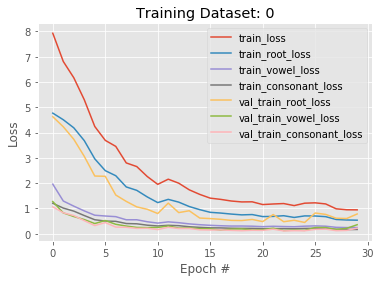

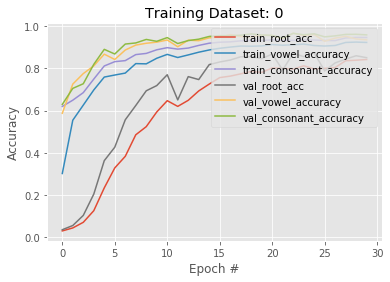

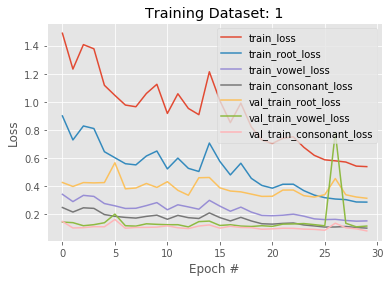

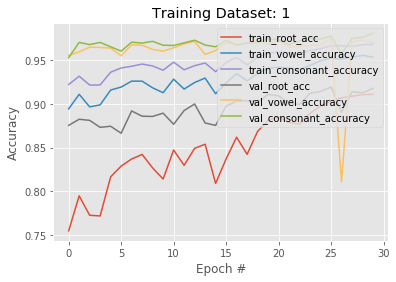

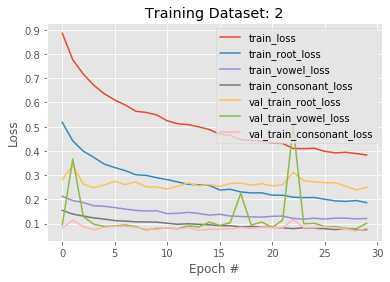

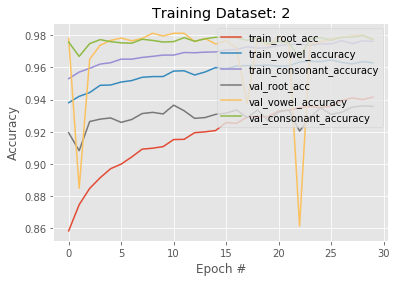

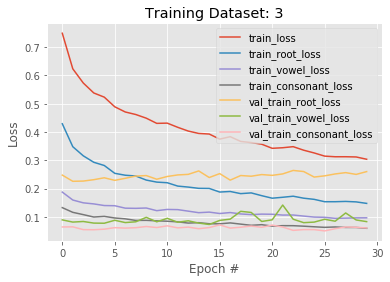

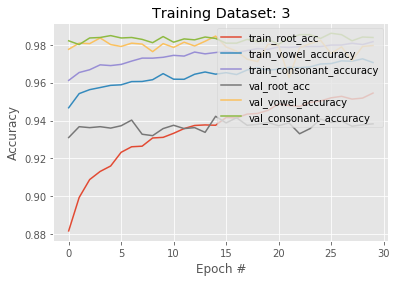

In [41]:
for dataset in range(4):
    plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
    plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')

In [42]:
del histories
gc.collect()

41138

In [43]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [44]:
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet('../data/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
5,Test_1_vowel_diacritic,2
6,Test_2_consonant_diacritic,0
7,Test_2_grapheme_root,19
8,Test_2_vowel_diacritic,0
9,Test_3_consonant_diacritic,0
